In [1]:
! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom pylibjpeg-openjpeg

In [2]:
import wandb
from datetime import datetime

In [3]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api_key_local = user_secrets.get_secret("wandb_api_key_local") 

wandb.login(key=wandb_api_key_local, host="http://8.210.101.57:8081")

wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for 8.210.101.57 to your netrc file: /root/.netrc


True

In [4]:
lr = 5e-4
batch_size = 32
wd = 1e-5
pos_weight = 20
backbone="resnet50"

In [5]:
wandb_entity='longyi'
model_name = "detection"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "pos_weight" : pos_weight,
    "backbone" : backbone
})
wandb.run.name = f'brief_segmentation_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

'brief_segmentation_detection_112631'

In [6]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import pylibjpeg
from tqdm import tqdm

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF

In [8]:
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit.
    """
    return dcm_ds.pixel_array * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept


def read_dcm(patient_dir, num_instance):
    dcm_path = os.path.join(patient_dir, f"{int(num_instance)}.dcm")
    ds = pydicom.dcmread(dcm_path)
    img2d = rescale_img_to_hu(ds)
    return normalize_hu(img2d)

def read_patient_dcm(patient_dir):

    num_slices = len(glob.glob(patient_dir + "/*.dcm"))
    print(f"total slices {num_slices}")
    imgs = np.zeros((num_slices, 512, 512))
    image_positions = np.zeros((num_slices, 3))
    image_orientations = np.zeros((num_slices, 6))
    pixel_spacings = np.zeros((num_slices, 2))
    slice_thicknesses = np.zeros((num_slices, 1))

    ignore_count = 1
    for i in range(num_slices):
        dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        while os.path.exists(dcm_path) == False:
            ignore_count += 1
            dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        ds = pydicom.dcmread(dcm_path)

        image_positions[i, :] = ds.ImagePositionPatient
        image_orientations[i, :] = ds.ImageOrientationPatient
        pixel_spacings[i, :] = ds.PixelSpacing
        slice_thicknesses[i, :] = ds.SliceThickness

        img2d = rescale_img_to_hu(ds)

        imgs[i] = img2d

    is_flip = False
    # check z is in good direction
    if image_positions[0, 2] < image_positions[1, 2]:
        is_flip = True
        # flip image in z direction
        imgs = np.flip(imgs, axis=0)
        image_positions = np.flip(image_positions, axis=0)
        pixel_spacings = np.flip(pixel_spacings, axis=0)
        slice_thicknesses = np.flip(slice_thicknesses, axis=0)

    return imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses, is_flip


def normalize_hu(data):
    # return (data - data.min()) / data.max()
    data = np.clip(data, a_min=-2242, a_max=2242) / 4484 + 0.5
    return data

def calculate_aspect(image_positions, pixel_spacings):
    """
    calculate z aspect, z 를 몇배로 늘여야 하는가야
    :param image_positions:
    :param pixel_spacings:
    :return:
    """
    height = image_positions[0, 2] - image_positions[1, 2]
    pixel_spacing = pixel_spacings[0, 0]
    aspect = height / pixel_spacing
    return aspect

In [9]:
DATA_DIR = "../input/cervicalspine"
TRAIN_IMAGES_DIR = "../input/rsna-2022-cervical-spine-fracture-detection/train_images"
SEG_IMAGES_DIR = "../input/cervicalspine/segmentation_images/segmentation_images"

In [10]:
seg_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_segment_idx.csv')).set_index('StudyInstanceUID')
seg_df.head()

,InstanceNumber,seg_idx,ImagePositionPatientZ
StudyInstanceUID,,,
1.2.826.0.1.3680043.10633,1,428,314.099976
1.2.826.0.1.3680043.10633,2,427,313.599976
1.2.826.0.1.3680043.10633,3,426,313.099976
1.2.826.0.1.3680043.10633,4,425,312.599976
1.2.826.0.1.3680043.10633,5,424,312.099976


In [11]:
from PIL import Image

class SegDataset(Dataset):
    def __init__(self, df, image_dir, seg_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.seg_dir = seg_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        slice_df = self.df.iloc[idx]
        UID = slice_df.name

        slice_img = read_dcm(os.path.join(TRAIN_IMAGES_DIR, UID), slice_df.InstanceNumber)
        slice_img = Image.fromarray(np.uint8(slice_img * 255), 'L')

        label_img = Image.open(os.path.join(self.seg_dir, UID, f"{int(slice_df.seg_idx)}.png"))
        # label_img = np.round(np.asarray(label_img, np.uint8) // 32)
        if self.transform:
            slice_img, label_img = self.transform(slice_img, label_img)

        return slice_img, label_img

In [12]:
total_slices = np.arange(len(seg_df))
np.random.shuffle(total_slices)
train_indices, val_indices = total_slices[:-3000], total_slices[-3000:]
train_df = seg_df.iloc[train_indices]
val_df = seg_df.iloc[val_indices]
train_df.head()

,InstanceNumber,seg_idx,ImagePositionPatientZ
StudyInstanceUID,,,
1.2.826.0.1.3680043.24606,215,214,-91.000
1.2.826.0.1.3680043.26442,260,109,-211.875
1.2.826.0.1.3680043.5002,397,2,44.500
1.2.826.0.1.3680043.5782,555,14,-1156.600
1.2.826.0.1.3680043.17960,25,246,164.250


In [13]:
class DataTransform(nn.Module):
    def __init__(self):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(256),
            T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

        self.target_transform = T.Compose([
            T.Resize(256),
            T.ToTensor(),
        ])

    def forward(self, x, y):
        x = self.transform(x)

        y = self.target_transform(y)
        y = y.gt(0).float()

        return x, y

transform = DataTransform()

In [14]:
train_dataset = SegDataset(train_df, TRAIN_IMAGES_DIR, SEG_IMAGES_DIR, transform=transform)
val_dataset = SegDataset(val_df, TRAIN_IMAGES_DIR, SEG_IMAGES_DIR, transform=transform)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Check small datasets

tensor(0.0892)


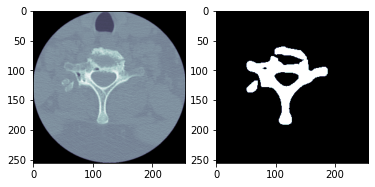

In [16]:

x, y = val_dataset[0]
_, axs = plt.subplots(1, 2)
axs[0].imshow(x.squeeze(), cmap='bone')
axs[1].imshow(y.squeeze(), cmap='bone')
print(y.mean())

In [17]:
print(x.min())
print(x.max())
print(y.min())
print(y.max())

tensor(-1.)
tensor(0.7804)
tensor(0.)
tensor(1.)


## Model

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, h):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(2*h, h, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, h, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, 2*h, kernel_size=1)
        )
    def forward(self, x):
        out = self.layers(x)
        out += x
        return out

class SegModel(nn.Module):
    def __init__(self, h, num_residual=8):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(1, 2*h, kernel_size=3, padding='same'),
            *[
                ResidualBlock(h) for _ in range(num_residual)
            ],
            nn.ReLU(inplace=True),
            nn.Conv2d(2*h, 1, kernel_size=1)
        )

    def forward(self, x):
        return self.layers(x)

In [19]:
import torchvision.models as models

def resnet18_gray():
    model = models.resnet18(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

def resnet50_gray():
    model = models.resnet50(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

In [20]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, self.n_features, kernel_size=1, padding='same'),
#             nn.AdaptiveMaxPool2d(output_size=(None, 1))
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same')
            parallel_modules.append(module)


        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i-1] if i > 0 else self.out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules



    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i+1)]
            parallel_output = parallel_outputs[-(i+1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out

# backbone = resnet18_gray()
# model = DetectionModel(backbone, channels=[64, 128, 256, 512], out_channels=64, n_features=1)

# input = torch.randn(1, 1, 512, 512)
# model(input).shape

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model

In [22]:
# model = SegModel(256, num_residual=8).to(device)
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# total_params

77833449

In [23]:
if backbone == 'resnet18':
    backbone = resnet18_gray()
    channels = [64, 128, 256, 512]
    
elif backbone == 'resnet50':
    backbone = resnet50_gray()
    channels = [64, 512, 1024, 2048]
    
    
model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=1).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

In [24]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))

In [25]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20], gamma=0.5)

In [26]:
def loss_fn(logits, y, pos_weight=10):
    loss = F.binary_cross_entropy_with_logits(logits, y, pos_weight=torch.tensor(pos_weight))
    return loss

In [27]:
def train_one_epoch(e, model, dataloader):

    model.train()
    train_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)
    
    for i, (x, y) in enumerate(train_iter):
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast(device == 'cuda'):
            logits = model(x)
            loss = loss_fn(logits, y, pos_weight=pos_weight)


        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # optimizer.step()

        train_iter.set_description(f"t {e} loss {loss.item():.4f}")

        losses.append(loss.item())

        
        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss' : loss.item(),
                'epoch' : e,
                'train_iteration' : i + epoch * epoch_iteration,
                **lr_logs,
            })
            
        if i % 100 == 0:
            with torch.no_grad():
                inference(model, val_dataset)
            model.train()

    return np.mean(losses)

In [28]:
def evaluate(e, model, dataloader):

    model.eval()
    eval_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)
    
    for i, (x, y) in enumerate(eval_iter):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y, pos_weight=pos_weight)

        eval_iter.set_description(f"e {e} loss {loss.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            wandb.log({
                'val_loss' : loss.item(),
                'epoch' : e,
                'val_iteration' : i + e * epoch_iteration,
            })

    return np.mean(losses)

In [29]:
def inference(model, dataset, i_list=None, wandb_log=True):
    model.eval()
    if i_list is None:
        i_list = np.random.choice(len(dataset) - 1, 4)
    x_list = []
    y_list = []
    for i in i_list:
        x, y = dataset[i]
        x_list.append(x)
        y_list.append(y)
    x, y = torch.stack(x_list), torch.stack(y_list)

    x = x.to(device)
    logits = model(x)
    pred = logits.sigmoid().gt(0.5).float()

    img = x * 0.5 + 0.5
    
    combined_img = np.concatenate((img.squeeze().cpu().numpy(), pred.squeeze().cpu().numpy(), y.squeeze().cpu().numpy()), axis=-1)

    combined_img = combined_img.reshape(-1, combined_img.shape[-1])
    if wandb.run is not None and wandb_log is True:
        wandb.log({
            'val_img_pred_label' : wandb.Image(combined_img),
        })

#     plt.imshow(combined_img, cmap='bone')
    # _, axs = plt.subplots(1, 2)
    # axs[0].imshow(img.squeeze().cpu(), cmap='bone')
    # axs[1].imshow(pred.squeeze().cpu())

# with torch.no_grad():
#     inference(model, val_dataset, i_list=None, wandb_log=False)

In [ ]:
epoch = 0

e 0 loss 0.0306: 100%|██████████| 94/94 [02:07<00:00,  1.35s/it]


epoch 0 train_loss 0.06767463143715131 eval_loss 0.03660994462985942


e 1 loss 0.0292: 100%|██████████| 94/94 [01:49<00:00,  1.16s/it]


epoch 1 train_loss 0.03715925819337084 eval_loss 0.03270094181866722


e 2 loss 0.0514: 100%|██████████| 94/94 [01:23<00:00,  1.13it/s]


epoch 2 train_loss 0.02978325054089453 eval_loss 0.06028260928677752


e 3 loss 0.0244: 100%|██████████| 94/94 [02:01<00:00,  1.29s/it]


epoch 3 train_loss 0.030678514695334492 eval_loss 0.03024190628623709


e 4 loss 0.0319: 100%|██████████| 94/94 [01:23<00:00,  1.13it/s]


epoch 4 train_loss 0.03833412198978115 eval_loss 0.03074718482713116


e 5 loss 0.0207: 100%|██████████| 94/94 [01:23<00:00,  1.12it/s]


epoch 5 train_loss 0.02499683832592099 eval_loss 0.024087660272229226


e 6 loss 0.0196: 100%|██████████| 94/94 [01:59<00:00,  1.27s/it]


epoch 6 train_loss 0.023781751684347197 eval_loss 0.02362622595094937


e 7 loss 0.0239:  44%|████▎     | 41/94 [00:35<00:48,  1.09it/s]

In [ ]:
epochs = 20

for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)

    with torch.no_grad():
        eval_loss = evaluate(epoch, model, val_loader)
        inference(model, val_dataset)

    print(f"epoch {epoch} train_loss {train_loss} eval_loss {eval_loss}")
    
    epoch += 1
    scheduler.step()
    # if wandb.run is not None:
    #     wandb.log({
    #         'average_train_loss' : train_loss,
    #         'average_eval_loss' : eval_loss,
    #     })

In [ ]:
state = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "epoch": epoch,
}
torch.save(state, f'{wandb.run.name}-epoch-{epoch}.pth')